In [1]:
# adapting code for Neural ODE from https://docs.kidger.site/diffrax/examples/neural_ode/

import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import keras
from keras import layers

/Users/william/miniforge3/envs/jax_arm/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Importing MNIST via Keras:

In [171]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 784).astype("float32") / 255.0


y_train = y_train.astype("int32")
y_test  = y_test.astype("int32")

Define $f_{\theta}$ vector field (Convolution):

In [162]:
class Func(eqx.Module):
    out_scale: jax.Array
    conv1: eqx.nn.Conv2d
    conv2: eqx.nn.Conv2d

    def __init__(self, *, key):
        k1, k2 = jax.random.split(key, 2)

        self.out_scale = jnp.array(1.0)

        self.conv1 = eqx.nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            padding=1,
            key=k1,
        )

        self.conv2 = eqx.nn.Conv2d(
            in_channels=16,
            out_channels=1,
            kernel_size=3,
            padding=1,
            key=k2,
        )


    def __call__(self, t, y, args=None):
        y = y.reshape(1, 28, 28)          
        y = jax.nn.relu(self.conv1(y))
        y = self.conv2(y)
        y = y.reshape(784)                
        return self.out_scale * y

Creating ODE solver feature map from initial data:

In [165]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, Func, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(key=key)

    def __call__(self, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Euler(),
            t0=0.0,
            t1=1.0,
            dt0=0.1,
            y0=y0,
            stepsize_controller=diffrax.ConstantStepSize(),
            saveat=diffrax.SaveAt(t1=True),
        )
        return solution.ys[0]

Wrapping ODE solve into classification:

In [166]:
class NODEClassifier(eqx.Module):
    ode: NeuralODE
    head: eqx.nn.Linear

    def __init__(self, Func, *, key, **kwargs):
        super().__init__(**kwargs)
        k1, k2 = jr.split(key, 2)
        self.ode = NeuralODE(Func, key=k1)
        self.head = eqx.nn.Linear(784, 10, key=k2)

    def __call__(self, x):
        h1 = self.ode(x)
        logits = self.head(h1)
        return logits

Run for NODE training:

In [169]:
def main_ODE(
    x_train=x_train,
    y_train=y_train,
    Func=Func,
    dataset_size=256,
    batch_size=32,
    lr=3e-3,
    steps=1000,
    seed=5678,
    print_every=100
):
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key = jr.split(key, 3)

    shuffle_key = jr.PRNGKey(0)
    perm = jr.permutation(shuffle_key, x_train.shape[0])
    x_train = x_train[perm]
    y_train = y_train[perm]
    
    #model = NeuralODE(data_size, width_size, depth, key=model_key)
    model = NODEClassifier(Func, key=model_key)
    optim = optax.adam(lr)

    @eqx.filter_value_and_grad
    def grad_loss(model, x_batch, y_batch):
        logits = jax.vmap(model)(x_batch)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, y_batch)
        return jnp.mean(loss)

    @eqx.filter_jit
    def make_step(x_batch, y_batch, model, opt_state):
        loss, grads = grad_loss(model, x_batch, y_batch)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
     
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    num_samples = x_train.shape[0]
    losses = []

    # Training loop
    for step in range(steps):
        start = (step * batch_size) % num_samples
        end = start + batch_size

        x_batch = x_train[start:end]
        y_batch = y_train[start:end]

        loss, model, opt_state = make_step(x_batch, y_batch, model, opt_state)
        losses.append(loss)
        if step % print_every == 0:
            print(f"Step {step}, Loss {loss}")
    return model, losses

In [170]:
model, losses = main_ODE()

Step 0, Loss 2.294827938079834
Step 100, Loss 0.4249168038368225
Step 200, Loss 0.6083523035049438
Step 300, Loss 0.19613400101661682
Step 400, Loss 0.27271661162376404
Step 500, Loss 0.5669422745704651
Step 600, Loss 0.22460409998893738
Step 700, Loss 0.09063446521759033
Step 800, Loss 0.1930949091911316
Step 900, Loss 0.11076069623231888


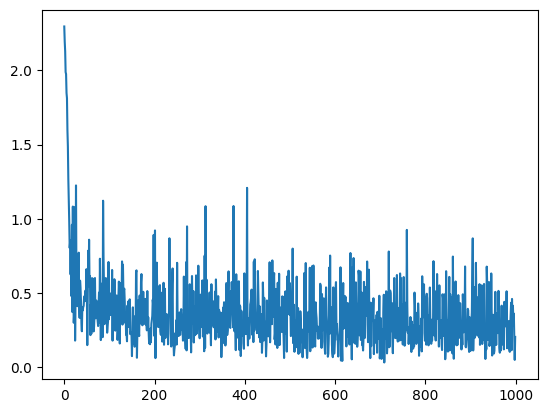

In [103]:
plt.plot(losses)

test evaluation:

In [104]:
correct = 0
total = 0
batch_size = 256

for i in range(0, x_test.shape[0], batch_size):
    x_batch = x_test[i:i+batch_size]
    y_batch = y_test[i:i+batch_size]

    logits = jax.vmap(model)(x_batch)      # (B, 10)
    preds = jnp.argmax(logits, axis=1)     # (B,)

    correct += jnp.sum(preds == y_batch)
    total += y_batch.shape[0]

accuracy = correct / total
print("Test accuracy:", f'{float(accuracy)*100}%')

Test accuracy: 92.3200011253357%


Test accuracy: 93.36000084877014%
